<a href="https://colab.research.google.com/github/Rayeeeeen/systematic-strategy-in-the-FX-market/blob/main/Implementing_a_systematic_strategy_in_the_FX_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forex predictions using Machine Learning
# Loading and preparing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/TP web scraping/TP web scraping/EURUSD_Candlestick_1_Hour_BID_19.10.2020-19.10.2023.csv")
for j in range(15):
  df["Local time"] =df["Local time"].apply(lambda x :x.replace("GMT+0"+str(j)+"00", ""))
df["Local time"] =df["Local time"].apply(lambda x :x.replace(":00.000", ""))
for i in range(25):
  df["Local time"] =df["Local time"].apply(lambda x :x.replace("0"+str(i)+":00", ""))
df['Local time']=pd.to_datetime(df['Local time'])
df.tail()

,Local time,Open,High,Low,Close,Volume
25866,2023-10-19,1.05364,1.05395,1.05342,1.05350,0.006221
25867,2023-10-19,1.05350,1.05369,1.05324,1.05338,0.004688
25868,2023-10-19,1.05336,1.05350,1.05305,1.05335,0.004742
25869,2023-10-19,1.05335,1.05349,1.05301,1.05331,0.005284
25870,2023-10-19,1.05330,1.05421,1.05282,1.05401,0.010679


In [ ]:
#Check if any zero volumes are available
indexZeros = df[ df['Volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["Volume"] == 0 )]
df.isna().sum()

Local time    0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64

In [ ]:
!pip install --upgrade scalecast

In [ ]:
from scalecast.Forecaster import Forecaster
from scalecast.Pipeline import Transformer, Reverter, Pipeline
from scalecast.util import (
    find_optimal_transformation,
    gen_rnn_grid,
    backtest_for_resid_matrix,
    get_backtest_resid_matrix,
    overwrite_forecast_intervals,
    infer_apply_Xvar_selection,
)
from scalecast import GridGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pandas_datareader as pdr

In [ ]:
close = df["Close"]

In [ ]:
'''f = Forecaster(
    y=close,
    current_dates=df['Local time'],
    future_dates = 24,
)
f.plot()
plt.show()
df.head(4)'''

"f = Forecaster(\n    y=close,\n    current_dates=df['Local time'],\n    future_dates = 24,\n)\nf.plot()\nplt.show()\ndf.head(4)"

In [ ]:
'''def forecaster(f):
    f.set_estimator('rnn')
    f.manual_forecast(
        lags = 24,
        layers_struct = [
            ('LSTM',{'units':36,'activation':'tanh'}),
        ],
        epochs=200,
        call_me = 'lstm',
    )

transformer = Transformer(
    transformers = [
        ('DetrendTransform',{'poly_order':2}),
        'DeseasonTransform',
    ],
)

reverter = Reverter(
    reverters = [
        'DeseasonRevert',
        'DetrendRevert',
    ],
    base_transformer = transformer,
)

pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

f = pipeline.fit_predict(f)'''

"def forecaster(f):\n    f.set_estimator('rnn')\n    f.manual_forecast(\n        lags = 24,\n        layers_struct = [\n            ('LSTM',{'units':36,'activation':'tanh'}),\n        ],\n        epochs=200,\n        call_me = 'lstm',\n    )\n\ntransformer = Transformer(\n    transformers = [\n        ('DetrendTransform',{'poly_order':2}),\n        'DeseasonTransform',\n    ],\n)\n\nreverter = Reverter(\n    reverters = [\n        'DeseasonRevert',\n        'DetrendRevert',\n    ],\n    base_transformer = transformer,\n)\n\npipeline = Pipeline(\n    steps = [\n        ('Transform',transformer),\n        ('Forecast',forecaster),\n        ('Revert',reverter),\n    ]\n)\n\nf = pipeline.fit_predict(f)"

In [ ]:
df.corr()

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,Open,High,Low,Close,Volume
Open,1.000000,0.999926,0.999925,0.999869,-0.393199
High,0.999926,1.000000,0.999877,0.999933,-0.388823
Low,0.999925,0.999877,1.000000,0.999933,-0.397563
Close,0.999869,0.999933,0.999933,1.000000,-0.393141
Volume,-0.393199,-0.388823,-0.397563,-0.393141,1.000000


array([[<Axes: title={'center': 'Local time'}>,
        <Axes: title={'center': 'Open'}>],
       [<Axes: title={'center': 'High'}>,
        <Axes: title={'center': 'Low'}>],
       [<Axes: title={'center': 'Close'}>,
        <Axes: title={'center': 'Volume'}>]], dtype=object)

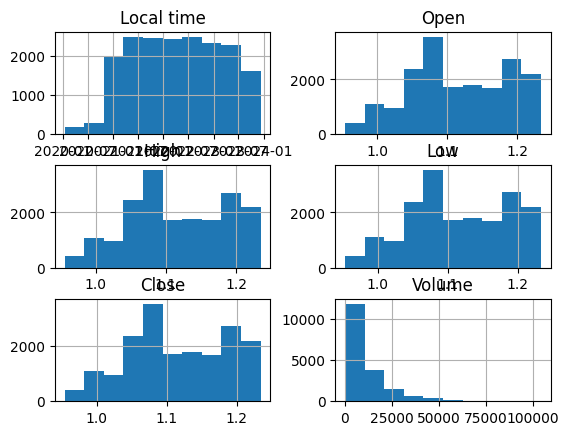

In [ ]:
df.hist()

there is a high corrolation between the variables using the correlation matrix

On va travailler sur le Close car les autres variables sont corrolés

In [ ]:
close = df["Close"]
rendement = df["Close"].pct_change()
volatilite_empirique = df["High"] - df["Low"]

<Axes: >

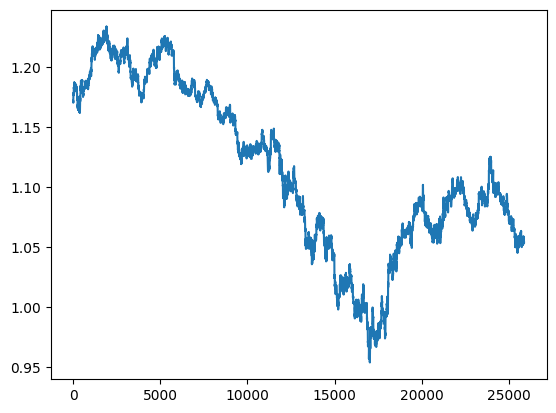

In [ ]:
close.plot()

<Axes: >

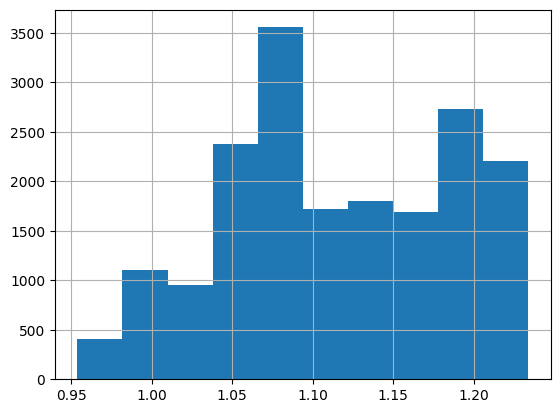

In [ ]:
close.hist()

<Axes: >

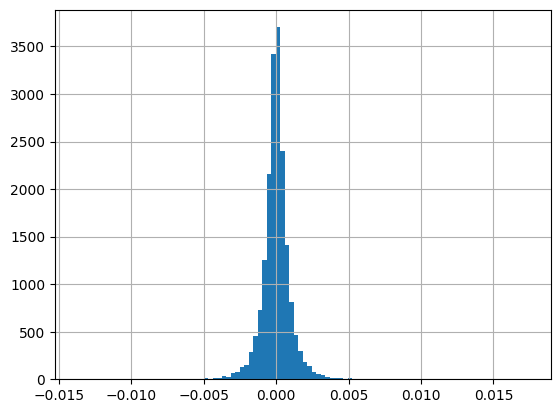

In [ ]:
rendement.hist(bins=100)

<Axes: >

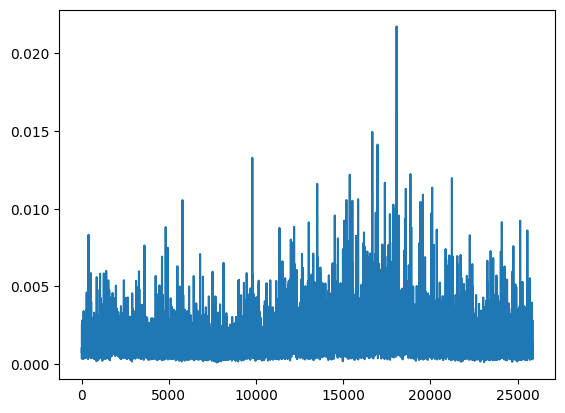

In [ ]:
volatilite_empirique.plot()


<Axes: >

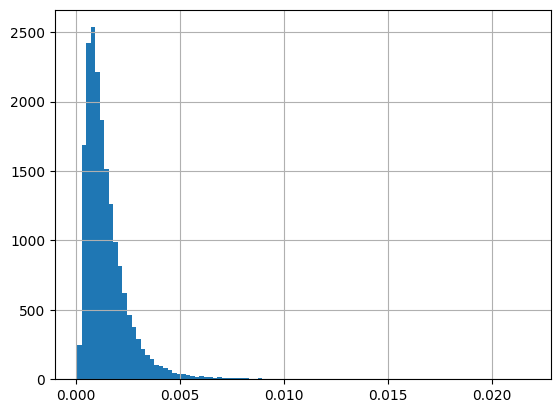

In [ ]:
volatilite_empirique.hist(bins=100)

#test de stationnarité des 3 seris temporels

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
result = adfuller(close, autolag='AIC')
# Extract and print the ADF test results
adf_statistic, p_value, used_lag, nobs, critical_values, icbest = result

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print(f'Lags Used: {used_lag}')
print(f'Number of Observations Used: {nobs}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Interpret the results
if p_value <= 0.05:
    print("The time series is likely stationary (reject the null hypothesis).")
else:
    print("The time series is likely non-stationary (fail to reject the null hypothesis).")

ADF Statistic: -1.0777385649975608
p-value: 0.7238673803533853
Lags Used: 1
Number of Observations Used: 18556
Critical Values:
   1%: -3.430702457687204
   5%: -2.861695773242642
   10%: -2.5668529139566507
The time series is likely non-stationary (fail to reject the null hypothesis).


In [ ]:
rendement = rendement.dropna()
result = adfuller(rendement, autolag='AIC')
# Extract and print the ADF test results
adf_statistic, p_value, used_lag, nobs, critical_values, icbest = result

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print(f'Lags Used: {used_lag}')
print(f'Number of Observations Used: {nobs}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Interpret the results
if p_value <= 0.05:
    print("The time series is likely stationary (reject the null hypothesis).")
else:
    print("The time series is likely non-stationary (fail to reject the null hypothesis).")


ADF Statistic: -52.23036730087196
p-value: 0.0
Lags Used: 6
Number of Observations Used: 18550
Critical Values:
   1%: -3.4307025717054715
   5%: -2.861695823631501
   10%: -2.5668529407778204
The time series is likely stationary (reject the null hypothesis).


Right now we can apply the machine learning models to this stationnary series

In [ ]:
from statsmodels.tsa.seasonal import STL

In [ ]:
df["volatilite_empirique"] = df["High"] - df["Low"]



In [ ]:

df['Local time']

0       2020-10-19
1       2020-10-19
2       2020-10-19
3       2020-10-19
4       2020-10-19
           ...    
25866   2023-10-19
25867   2023-10-19
25868   2023-10-19
25869   2023-10-19
25870   2023-10-19
Name: Local time, Length: 18558, dtype: datetime64[ns]

In [ ]:
df.head()

,Local time,Open,High,Low,Close,Volume,volatilite_empirique
0,2020-10-19,1.17181,1.17198,1.17122,1.17126,2539.9285,0.00076
1,2020-10-19,1.17129,1.17158,1.17112,1.17156,5924.8999,0.00046
2,2020-10-19,1.17154,1.17234,1.17149,1.17234,16521.6699,0.00085
3,2020-10-19,1.17235,1.17249,1.17143,1.17152,33720.1289,0.00106
4,2020-10-19,1.17153,1.17153,1.17085,1.17145,27330.2793,0.00068


In [ ]:
df['volatilite_empirique']

0        0.00076
1        0.00046
2        0.00085
3        0.00106
4        0.00068
          ...   
25866    0.00053
25867    0.00045
25868    0.00045
25869    0.00048
25870    0.00139
Name: volatilite_empirique, Length: 18558, dtype: float64

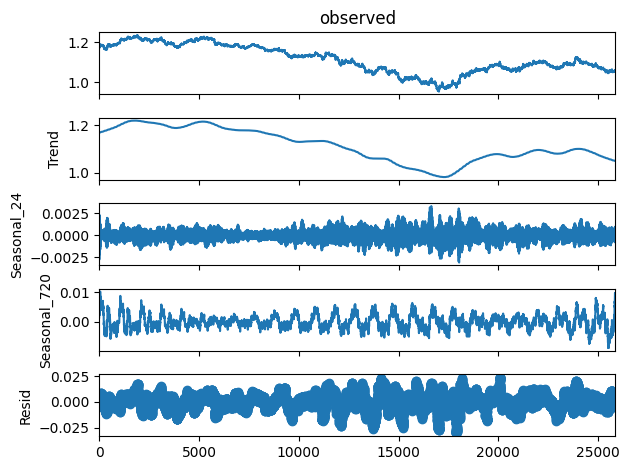

In [ ]:
from statsmodels.tsa.seasonal import MSTL
import matplotlib.pyplot as plt
res = MSTL(df['Close'], periods=(24, 24*30)).fit()
res.plot()
plt.tight_layout()
plt.show()

In [ ]:
! pip install pandas_ta

Volatility (ATR): Helps in understanding the potential range of price

A high ATR value indicates that the market is experiencing significant price swings and increased volatility. This may imply greater risk, as wider price fluctuations can result in potential losses. Traders often use the ATR to set stop-loss levels and determine position sizes, factoring in their risk tolerance. For instance, a trader may set wider stop-loss orders in a high-volatility market and adjust their position size accordingly to manage risk.movements.


Momentum (RSI): Indicates the strength and speed of price movements.


Trend Direction (SMA): Provides information about the general trend over different time frames.


Price Reference Point (Midprice): Offers a central reference for a specific period.

# Target categories

In [ ]:
#Target flexible way
pipdiff = 500*1e-5 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length

    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend

    return trendcat

# Quick analysis example

## Can we use the RSI alone as a trend indicator?

# Machine learning for trend prediction

## 1 - the perfect model with precise prediction

## 2 - less perfect model still with > 40% precision

## 3 - much less perfect model with precision >35% taking into account our strategy, and our TP/SL ratio

### can't let an automated program run your trades
### it can be your version of a smart indicator (based on machine learning)

## 4 - Our target has categorical values so we need a classificator, KNN?

## Splitting features and target

In [ ]:
def to_sequences(dataset, seq_size):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])

    return np.array(x),np.array(y)

In [ ]:
DF_LSTM=df[['Open',	'High',	'Low',	'Close']]



In [ ]:
import tensorflow
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
def Forecaster(df, seq_size):
    predicted_prices = []  # Initialize as an empty list

    for column in df.columns:  # Renamed 'elm' to 'column' for clarity
        dataset = df[column].values
        dataset = dataset.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        train_size = int(len(dataset) * 0.66)
        test_size = len(dataset) - train_size
        train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
        train_X, train_Y = to_sequences(train, seq_size)
        test_X, test_Y = to_sequences(test, seq_size)

        train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
        test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

        print('Single LSTM with hidden Dense for the ' + column + ' price')
        model = Sequential()
        model.add(LSTM(64, input_shape=(None, seq_size)))
        model.add(Dense(32))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20,
                        verbose=1, mode='auto', restore_best_weights=True)
        model.fit(train_X, train_Y, validation_data=(test_X, test_Y),
              verbose=2, epochs=50)
        test_Predict = model.predict(test_X)
        test_Predict = scaler.inverse_transform(test_Predict)
        predicted_prices.append(test_Predict[-1, 0])  # Append to the list
    model.save('my_lstm_model.h5')
    new_df = pd.DataFrame([predicted_prices], columns=df.columns)  # Create a new DataFrame
    df = pd.concat([df, new_df], ignore_index=True)  # Concatenate DataFrames with proper indexing

    return df  # Return the modified DataFrame


In [ ]:
df1=Forecaster(DF_LSTM,10)

In [ ]:
df1

,Open,High,Low,Close
0,1.171810,1.171980,1.171220,1.171260
1,1.171290,1.171580,1.171120,1.171560
2,1.171540,1.172340,1.171490,1.172340
3,1.172350,1.172490,1.171430,1.171520
4,1.171530,1.171530,1.170850,1.171450
...,...,...,...,...
18554,1.053500,1.053690,1.053240,1.053380
18555,1.053360,1.053500,1.053050,1.053350
18556,1.053350,1.053490,1.053010,1.053310
18557,1.053300,1.054210,1.052820,1.054010


In [ ]:
import pandas_ta as ta
df1['ATR'] = df1.ta.atr(length=20)
df1['RSI'] = df1.ta.rsi()
df1['Average'] = df1.ta.midprice(length=1) #midprice
df1['MA40'] = df1.ta.sma(length=40)
df1['MA80'] = df1.ta.sma(length=80)
df1['MA160'] = df1.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df1['slopeMA40'] = df1['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df1['slopeMA80'] = df1['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df1['slopeMA160'] = df1['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df1['AverageSlope'] = df1['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df1['RSISlope'] = df1['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [ ]:
# mytarget(barsfront to take into account, dataframe)
df1['mytarget'] = mytarget(16, df1)
df1.head(50)

To output multiple subplots, the figure containing the passed axes is being cleared.


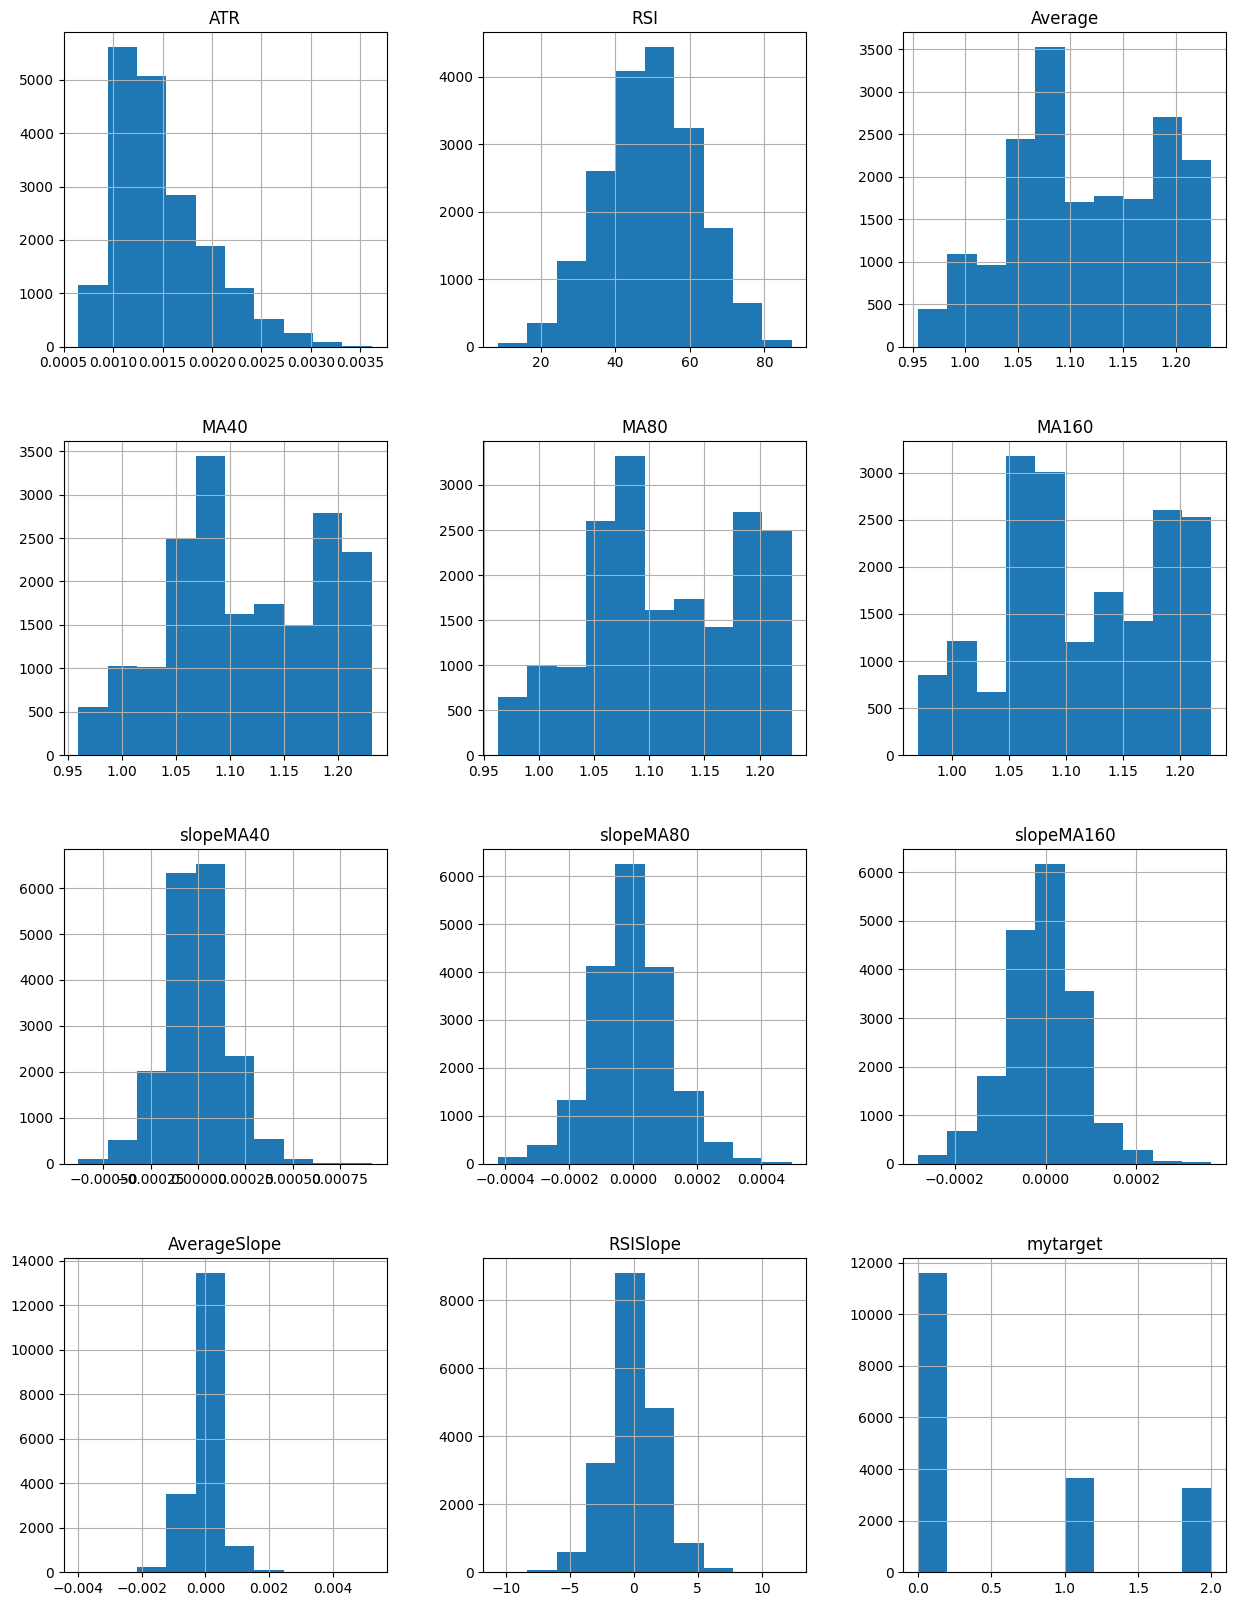

In [ ]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df1[[ 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']]
df_model.hist(ax = ax)
plt.show()

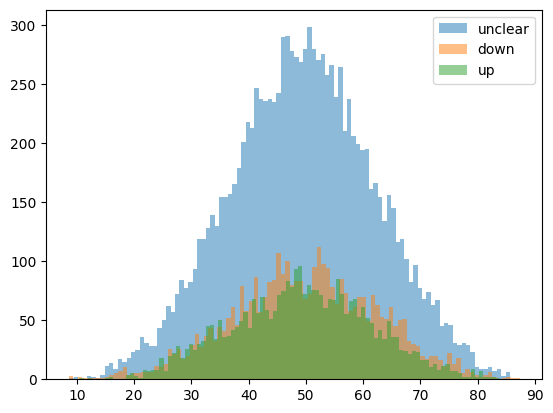

In [ ]:
from matplotlib import pyplot
df_up=df1.RSI[ df1['mytarget'] == 2 ]
df_down=df1.RSI[ df1['mytarget'] == 1 ]
df_unclear=df1.RSI[ df1['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

In [ ]:
df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(y)

164      1.0
165      1.0
166      1.0
167      1.0
168      1.0
        ... 
18536    0.0
18537    0.0
18538    0.0
18539    0.0
18540    0.0
Name: mytarget, Length: 18377, dtype: float64


In [ ]:
'''from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)'''

## Fitting the KNN model

In [ ]:
'''from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)'''

## Quick evaluation of our fitting

In [ ]:
'''from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

'''

## More powerful model XGBoost

In [ ]:
'''from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))'''

## !!Data sampling shouldn't be random

In [ ]:
#random sampling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
#sequential sampling
train_index = int(0.8 * len(X))
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]
scaler = MinMaxScaler(feature_range=(0, 1))


model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test =accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 94.8364%
****Test Results****
Accuracy: 53.2100%


In [ ]:
# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy Gambler: 34.98%


## Which features are most important for our model?

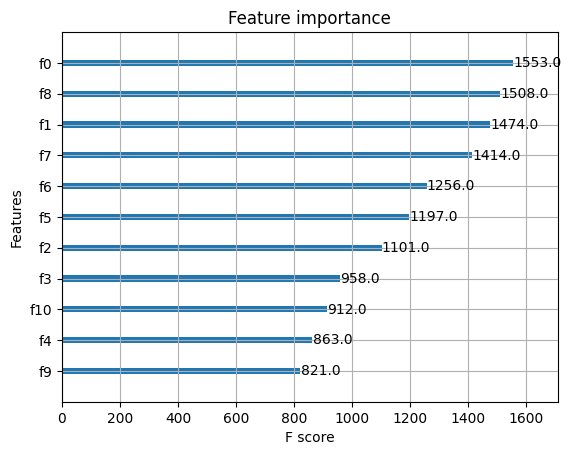

In [ ]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()

In [ ]:
attributes=['ATR', 'RSI', 'slopeMA80', 'slopeMA160',]
X_1 = df_model[attributes]

In [ ]:
train_index1 = int(0.8 * len(X_1))
X_1 = scaler.fit_transform(X)
X_train1, X_test1 = X_1[:train_index1], X[train_index1:]
y_train1, y_test1 = y[:train_index1], y[train_index1:]


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

# Assuming you have your data loaded in X_train and y_train

# Define the hyperparameters and their respective search ranges
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize an XGBoost classifier
model1 = XGBClassifier()

# Grid Search
grid_search = GridSearchCV(model1, param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train1, y_train1)

# Random Search
random_search = RandomizedSearchCV(model1, param_distributions=param_grid,
                                   n_iter=10, scoring='accuracy', cv=3)
random_search.fit(X_train1, y_train1)

# Print the best parameters from both searches
print("Grid Search - Best Parameters:", grid_search.best_params_)
print("Random Search - Best Parameters:", random_search.best_params_)



Grid Search - Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8}
Random Search - Best Parameters: {'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


#Using the Grid Search

In [ ]:
xgb_model=XGBClassifier(**{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8})
xgb_model.fit(X_train1, y_train1)
pred_train1 = xgb_model.predict(X_train1)
pred_test1 = xgb_model.predict(X_test1)

acc_train1 = accuracy_score(y_train1, pred_train1)
acc_test1 =accuracy_score(y_test1, pred_test1)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train1))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test1))

****Train Results****
Accuracy: 62.6284%
****Test Results****
Accuracy: 63.7378%


#Using the Random search

In [ ]:
xgb_model1=XGBClassifier(**{'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0})
xgb_model1.fit(X_train1, y_train1)
pred_train1 = xgb_model1.predict(X_train1)
pred_test1 = xgb_model1.predict(X_test1)

acc_train1 = accuracy_score(y_train1, pred_train1)
acc_test1 =accuracy_score(y_test1, pred_test1)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train1))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test1))

****Train Results****
Accuracy: 62.6148%
****Test Results****
Accuracy: 63.6561%


# Automated orders using python and Machine Learning
## Previous videos
### 1 - Install Anaconda, Jupyter NB, Pandas_TA (Technical Analysis)
### 2 - Download price data from online resources, and add our technical indicators to our exchange price dataframe
### 3 - Fit a Machine learning model and predict future price trends using KNN and XGBOOST classifiers
### 4 - Save and Load a ML model,
### - according to the model's advice
### - passing orders (sell/buy) automatically
### - send an email notification about newly applied trading operations

## Load Machine Learning Model from Disk and Test it

In [ ]:
import joblib

# save your ML model to disk
filename = 'mymodel1.sav'
joblib.dump(model, filename)

#load the model from disk
loaded_model = joblib.load('mymodel1.sav')

## Live Automated Orders with email notification

In [ ]:
from apscheduler.schedulers.blocking import BlockingScheduler
import json
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleCollector
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails


import smtplib
gmail_user = 'email@gmail.com'
gmail_password = 'email password here'
sent_from = gmail_user
to = ['email@gmail.com']
subject = 'info CHF'


In [ ]:
ModelPrediction = 0
def some_job():
    access_token="INSERT TOKEN HERE, YOU GET IT FROM YOUR OANDA ACCOUNT"
    collector = CandleCollector(access_token, Pair.USD_CHF, Gran.H4)
    candles = collector.grab(2*161)

    dfstream = pd.DataFrame(columns=['Open','Close','High','Low'])
    i=0
    for candle in candles:
        dfstream.loc[i, ['Open']] = float(str(candle.bid.o))
        dfstream.loc[i, ['Close']] = float(str(candle.bid.c))
        dfstream.loc[i, ['High']] = float(str(candle.bid.h))
        dfstream.loc[i, ['Low']] = float(str(candle.bid.l))
        i=i+1

    dfstream['Open'] = dfstream['Open'].astype(float)
    dfstream['Close'] = dfstream['Close'].astype(float)
    dfstream['High'] = dfstream['High'].astype(float)
    dfstream['Low'] = dfstream['Low'].astype(float)

    #dfstream['Average'] = (dfstream['High']+dfstream['Low'])/2
    #dfstream['MA40'] = dfstream['Open'].rolling(window=40).mean()
    #dfstream['MA80'] = dfstream['Open'].rolling(window=80).mean()
    #dfstream['MA160'] = dfstream['Open'].rolling(window=160).mean()

    import numpy as np
    import pandas_ta as ta
    #attributes=['ATR', 'RSI', 'Average',
    #'MA40', 'MA80', 'MA160', 'slopeMA40',
    #'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    dfstream['ATR'] = dfstream.ta.atr(length=20)
    dfstream['RSI'] = dfstream.ta.rsi()
    dfstream['Average'] = dfstream.ta.midprice(length=1) #midprice
    dfstream['MA40'] = dfstream.ta.sma(length=40)
    dfstream['MA80'] = dfstream.ta.sma(length=80)
    dfstream['MA160'] = dfstream.ta.sma(length=160)

#from scipy.stats import linregress
#def get_slope(array):
#    y = np.array(array)
#    x = np.arange(len(y))
#    slope, intercept, r_value, p_value, std_err = linregress(x,y)
#    return slope

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    backrollingN = 6
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    dfstream['slopeMA40'] = dfstream['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA80'] = dfstream['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA160'] = dfstream['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['AverageSlope'] = dfstream['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['RSISlope'] = dfstream['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

    #________________________________________________________________________________________________
    X_stream = dfstream.iloc[[320]]# !!! Index takes last CLOSED candle
    #attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160',
    #'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    X_model = X_stream[attributes]

    # Apply the model for predictions
    ModelPrediction = loaded_model.predict(X_model)

    msg = str(ModelPrediction) # 0 no clear trend, 1 downtrend, 2 uptrend
    #------------------------------------
    # send email with
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
    server.ehlo()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, msg)
    server.close()
    #________________________________________________________________________________________________


    # EXECUTING ORDERS
    accountID = "1432-432-0000" #use your account ID
    client = API(access_token)

    candles = collector.grab(1)
#    for candle in candles:
#        print(candle.bid.o)
#        print(candle.bid.c)

    pipdiff = 500*1e-5 #for TP
    SLTPRatio = 2 #pipdiff/Ratio gives SL

    TPBuy = float(str(candle.bid.o))+pipdiff
    SLBuy = float(str(candle.bid.o))-(pipdiff/SLTPRatio)
    TPSell = float(str(candle.bid.o))-pipdiff
    SLSell = float(str(candle.bid.o))+(pipdiff/SLTPRatio)

    #Sell
    if ModelPrediction == 1:
        mo = MarketOrderRequest(instrument="USD_CHF", units=-1000, takeProfitOnFill=TakeProfitDetails(price=TPSell).data, stopLossOnFill=StopLossDetails(price=SLSell).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)
    #Buy
    elif ModelPrediction == 2:
        mo = MarketOrderRequest(instrument="USD_CHF", units=1000, takeProfitOnFill=TakeProfitDetails(price=TPBuy).data, stopLossOnFill=StopLossDetails(price=SLBuy).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)

## Executing orders automatically every 4 Hours

In [ ]:
#some_job()

###################################################################
## Interval time job ##############################################
scheduler = BlockingScheduler(job_defaults={'misfire_grace_time': 15*60})
scheduler.add_job(some_job, 'cron', day_of_week='mon-fri', hour='*/4', minute=5, jitter=120, timezone='America/New_York')
#scheduler.add_job(some_job, 'interval', hours=4)
scheduler.start()